This code is used to zonally and vertically average as well as taper in latitude the dynamical fields – u_FT, v_FT, and BL depth (h) for the SBLM simulations. A netcdf4 file for each of the three fields.

Author: Alex Gonzalez (alex.gonzalez@whoi.edu). Oct 2023.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import netCDF4

from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
lats = -30.
latn = 30.
lonw = 235
lone = 270

mn_st = 12
mn_end = 1

ntap = 20
# at 0.25 deg resolution, this is a 5 deg tapering

In [4]:
# land-sea mask
fn_lsm = '/Volumes/alex.gonzalez/ERA5_smooth_clm/lsm_era5.nc'
# load the land-sea mask here and do a where statement further down   
data_lsm = xr.open_dataset(fn_lsm)
lsm = data_lsm['lsm'][0,::-1,:].sel(latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [5]:
figfolder = './'

dri = '/Volumes/alex.gonzalez/ERA5_smooth_clm/'
fn  = 'va_1979-2021_monclm_hres.nc'
data_v = xr.open_dataset(dri+fn)

fn  = 'ua_1979-2021_monclm_hres.nc'
data_u = xr.open_dataset(dri+fn)

fn  = 'blh_1979-2021_monclm_hres.nc'
data_h = xr.open_dataset(dri+fn)

lev0 = 700
lev1 = 800

In [6]:
data_u

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, longitude: 1440, latitude: 721, level: 12)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 700 750 775 800 825 850 875 900 925 950 975 1000
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    u          (time, level, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 11 16:13:32 2023: cdo ymonavg ua_1979-2021_hres.nc ...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [7]:
time = data_v['time']
lev = data_v['level'].sel(level=slice(700,1000))
lat = data_v['latitude'].sel(latitude=slice(latn,lats))
lon = data_v['longitude'].sel(longitude=slice(lonw,lone))

ntim = len(time)
nlev = len(lev)
nlat = len(lat)
nlon = len(lon)

In [8]:
nmon = ntim

In [9]:
# applies the Hann window at northern and southern boundaries as a function of month
def Hann_window(field_monlat,ntap):
    t = np.arange(0,ntap+1,1)
    hannl = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    t = np.arange(ntap,ntap*2+1,1)
    hannr = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    [nmon,nlat] = field_monlat.shape
    field = field_monlat
    fieldf = np.zeros((nmon,nlat))
    
    fieldf[:,:ntap+1] = field[:,:ntap+1]*hannl
    fieldf[:,ntap+1:nlat-ntap-1] = field[:,ntap+1:nlat-ntap-1]
    fieldf[:,nlat-ntap-1:] = field[:,nlat-ntap-1:]*hannr
    return fieldf

In [10]:
lat_sblm = lat[::-1]
lat_sblm

<xarray.DataArray 'latitude' (latitude: 241)>
array([-30.  , -29.75, -29.5 , ...,  29.5 ,  29.75,  30.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y

In [11]:
va = data_v['v'][:,:,::-1,:].sel(time=time,level=slice(lev0,lev1),latitude=slice(lats,latn),longitude=slice(lonw,lone)).mean(dim=('level'))
ua = data_u['u'][:,:,::-1,:].sel(time=time,level=slice(lev0,lev1),latitude=slice(lats,latn),longitude=slice(lonw,lone)).mean(dim=('level'))
h = data_h['blh'][:,::-1,:].sel(time=time,latitude=slice(lats,latn),longitude=slice(lonw,lone))

In [12]:
va_xavg = va.where(lsm==0).mean(dim='longitude') 
ua_xavg = ua.where(lsm==0).mean(dim='longitude')  
h_xavg = h.where(lsm==0).mean(dim='longitude') 

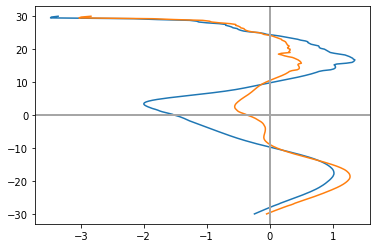

In [13]:
plt.plot(va_xavg[11,:],va['latitude'])
plt.plot(va_xavg[2,:],va['latitude'])
plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [14]:
va_xavg

<xarray.DataArray 'v' (time: 12, latitude: 241)>
array([[ 0.10618699,  0.13614486,  0.16626886, ..., -3.2111182 ,
        -3.183992  , -3.0970135 ],
       [ 0.07874471,  0.11213316,  0.1450469 , ..., -2.661608  ,
        -2.6449807 , -2.5592198 ],
       [-0.04859681, -0.01672371,  0.01635052, ..., -3.0295386 ,
        -2.9929783 , -2.83887   ],
       ...,
       [-0.3387248 , -0.31245747, -0.28518274, ..., -1.6619859 ,
        -1.6449844 , -1.455209  ],
       [-0.3696182 , -0.34763655, -0.32463637, ..., -2.946061  ,
        -2.9417102 , -2.8170953 ],
       [-0.24162067, -0.21145935, -0.1811665 , ..., -3.480816  ,
        -3.4691932 , -3.3600643 ]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0

In [15]:
va_clm_orig = va_xavg
va_clm_hann = Hann_window(va_xavg,ntap)
va_clm_hann_xr = xr.DataArray(va_clm_hann, coords=[time,lat_sblm], dims=['time','latitude'])

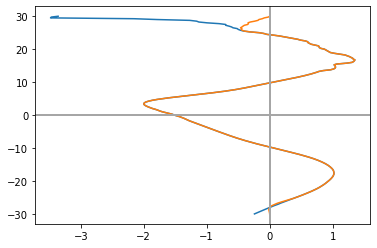

In [16]:
plt.plot(va_clm_orig[11,:],lat_sblm)
plt.plot(va_clm_hann_xr[11,:],lat_sblm)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [17]:
ua_clm_orig = ua_xavg
ua_clm_hann = Hann_window(ua_xavg,ntap)
ua_clm_hann_xr = xr.DataArray(ua_clm_hann, coords=[time,lat_sblm], dims=['time','latitude'])

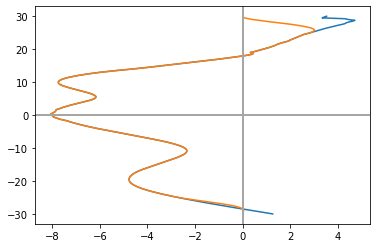

In [18]:
plt.plot(ua_clm_orig[11,:],lat_sblm)
plt.plot(ua_clm_hann_xr[11,:],lat_sblm)

plt.axvline(0, color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [19]:
print(ua_clm_hann_xr[0,100])

<xarray.DataArray ()>
array(-6.2070899)
Coordinates:
    time      datetime64[ns] 2021-01-01
    latitude  float32 -5.0


In [20]:
# applies the Hann window at southern boundary as a function of month
def Hann_window_southern(field_monlat,ntap):
    t = np.arange(0,ntap+1,1)
    hannl = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    t = np.arange(ntap,ntap*2+1,1)
    hannr = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    [nmon,nlat] = field_monlat.shape
    field = field_monlat
    fieldf = np.zeros((nmon,nlat))
    
    fieldf[:,:ntap+1] = field[:,:ntap+1]*hannl
    fieldf[:,ntap+1:] = field[:,ntap+1:]
    return fieldf

In [21]:
# applies the Hann window at northern boundary as a function of month
def Hann_window_northern(field_monlat,ntap):
    t = np.arange(0,ntap+1,1)
    hannl = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    t = np.arange(ntap,ntap*2+1,1)
    hannr = 0.5*(1 - np.cos(2*np.pi*t/(ntap*2)))
    
    [nmon,nlat] = field_monlat.shape
    field = field_monlat
    fieldf = np.zeros((nmon,nlat))
    
    fieldf[:,:nlat-ntap-1] = field[:,:nlat-ntap-1]
    fieldf[:,nlat-ntap-1:] = field[:,nlat-ntap-1:]*hannr 
    return fieldf

In [22]:
h_S_xr = h_xavg[:,:ntap+1].mean(dim='latitude')
h_N_xr = h_xavg[:,nlat-ntap-1:].mean(dim='latitude')
h_S_xr

<xarray.DataArray 'blh' (time: 12)>
array([753.34576, 759.51984, 789.48975, 847.2676 , 927.2543 , 956.55383,
       996.1222 , 978.8274 , 940.1593 , 879.237  , 817.29083, 778.26447],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01

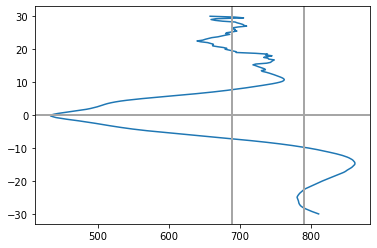

In [23]:
id_mon = 2
plt.plot(h_xavg[id_mon,:],lat_sblm)
plt.axvline(h_S_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axvline(h_N_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [24]:
h_clm_orig = h_xavg

In [25]:
h_anom_S = h_xavg - h_S_xr
h_anom_hann_S = Hann_window_southern(h_anom_S,ntap) + h_anom_S*0
h_anom_hann_S

<xarray.DataArray 'blh' (time: 12, latitude: 241)>
array([[-0.00000000e+00, -5.88583585e-02, -2.43317881e-01, ...,
        -1.20301453e+02, -1.28315491e+02, -1.47372131e+02],
       [-0.00000000e+00, -9.95250079e-03, -5.41443263e-02, ...,
        -7.51311035e+01, -8.48049927e+01, -1.12314575e+02],
       [ 0.00000000e+00,  1.09524474e-01,  3.56441435e-01, ...,
        -8.45228271e+01, -9.70081177e+01, -1.31593445e+02],
       ...,
       [-0.00000000e+00, -1.07137136e-02, -4.10914362e-02, ...,
        -2.79831848e+02, -2.87236450e+02, -3.03821350e+02],
       [-0.00000000e+00, -2.83820420e-03, -1.02777134e-02, ...,
        -1.61140259e+02, -1.67041565e+02, -1.78529236e+02],
       [-0.00000000e+00, -5.38165446e-02, -1.94344525e-01, ...,
        -7.41054688e+01, -8.03400269e+01, -9.27576294e+01]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0

In [26]:
h_clm_hann_S = h_anom_hann_S + h_S_xr
h_clm_hann_S_xr = xr.DataArray(h_clm_hann_S, coords=[time,lat_sblm], dims=['time','latitude'])

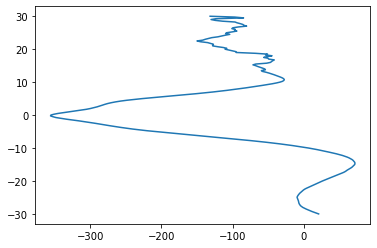

In [27]:
plt.plot(h_anom_S[2,:],lat_sblm)

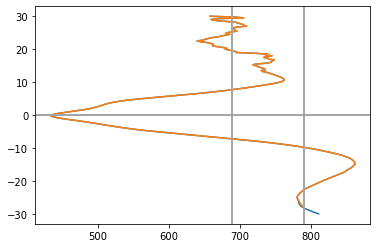

In [28]:
id_mon = 2
plt.plot(h_clm_orig[id_mon,:],lat_sblm)
plt.plot(h_clm_hann_S_xr[id_mon,:],lat_sblm)

plt.axvline(h_S_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axvline(h_N_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [29]:
h_anom_N = h_clm_hann_S_xr - h_N_xr
h_anom_hann_N = Hann_window_northern(h_anom_N.values,ntap) + h_anom_N*0
h_clm_hann_N = h_anom_hann_N + h_N_xr
h_clm_hann_xr = xr.DataArray(h_clm_hann_N, coords=[time,lat_sblm], dims=['time','latitude'])

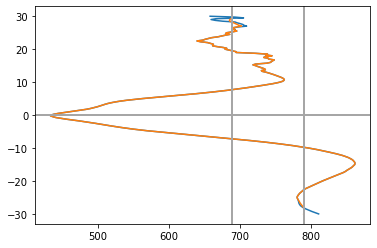

In [30]:
id_mon = 2
plt.plot(h_clm_orig[id_mon,:],lat_sblm)
plt.plot(h_clm_hann_xr[id_mon,:],lat_sblm)

plt.axvline(h_S_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axvline(h_N_xr[id_mon], color='0.65', linewidth = 2.0)
plt.axhline(0, color='0.65', linewidth = 2.0)

In [31]:
# Now save one large file with all the months

In [32]:
# variable h
# save nc file
dro = '/Users/alexgonzalez/Downloads/'#'/Volumes/alex.gonzalez/IBM/Idealized_BL_model/progs/data_preproc/monthly/'

# save nc file
h_clm_hann_xr.name = 'h'
h_clm_hann_xr.attrs['long_name'] = 'Boundary layer height'
h_clm_hann_xr.attrs['units'] = 'm'
h_clm_hann_xr.attrs['dataset'] = 'ERA5'
h_clm_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
h_clm_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'
fn_output = 'h_forcing2.nc'

h_clm_hann_xr.to_netcdf(path=dro+fn_output)

In [32]:
ua_clm_hann_xr.name = 'uol'
ua_clm_hann_xr.attrs['long_name'] = 'zonal winds in the overlying layer'
ua_clm_hann_xr.attrs['units'] = 'm s**-1'
ua_clm_hann_xr.attrs['dataset'] = 'ERA5'
ua_clm_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
ua_clm_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'

fn_output = 'uol_forcing.nc'
ua_clm_hann_xr.to_netcdf(path=dro+fn_output)

In [33]:
ua_clm_hann_xr

<xarray.DataArray 'uol' (time: 12, latitude: 241)>
array([[ 0.00000000e+00,  1.56700797e-03,  2.05235344e-04, ...,
         8.16755493e-02,  2.09423598e-02,  0.00000000e+00],
       [ 0.00000000e+00,  4.48844583e-05, -5.55824146e-03, ...,
         1.14324275e-01,  2.91132880e-02,  0.00000000e+00],
       [ 0.00000000e+00,  9.94484546e-03,  3.38640467e-02, ...,
         1.24734303e-01,  3.15644721e-02,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  2.46484628e-02,  9.29591219e-02, ...,
         4.68248915e-02,  1.18356159e-02,  0.00000000e+00],
       [ 0.00000000e+00,  1.57201025e-02,  5.74222168e-02, ...,
         6.45990939e-02,  1.66595191e-02,  0.00000000e+00],
       [ 0.00000000e+00,  6.43632161e-03,  2.03703573e-02, ...,
         8.16386810e-02,  2.10597964e-02,  0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-01 2021-02-01 ... 2021-12-01
  * latitude  (latitude) float32 -30.0 -29.75 -29.5 -29.25 ... 29.5 29.75 30.0
Attributes:
    long_name:  zonal winds in the overlying layer
    units:      m s**-1
    dataset:    ERA5
    notes:      longitudinally-averaged, ocean only
    taper:      Tapering within 5 degrees of north and south boundaries

In [33]:
#dro = './'
va_clm_hann_xr.name = 'vol'
va_clm_hann_xr.attrs['long_name'] = 'meridional winds in the overlying layer'
va_clm_hann_xr.attrs['units'] = 'm s**-1'
va_clm_hann_xr.attrs['dataset'] = 'ERA5'
va_clm_hann_xr.attrs['notes'] = 'longitudinally-averaged, ocean only'
va_clm_hann_xr.attrs['taper'] = 'Tapering within 5 degrees of north and south boundaries'

fn_output = 'vol_forcing.nc'
va_clm_hann_xr.to_netcdf(path=dro+fn_output)

In [41]:
print(dro+fn_output)

./vol_forcing.nc
